## City Dataset Analysis

This notebook follows the CRISP-DM framework with a focus on Step 2 (Data Understanding)
and Step 3 (Data Preparation). Add your code in the provided cells.

Source of data: simplemaps.com

### CRISP-DM Step 1: Business Understanding

Goal: build a clean city-level dataset that supports analysis of urban populations and
capital status across countries. The focus here is data understanding and preparation.


### Imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import plotly.express as px

### CRISP-DM Step 2: Data Understanding

Goal: collect the data, describe its structure, explore distributions, and assess quality.


#### 2.1 Data Collection (Data Loading)


In [2]:
# Load combined city dataset
data_path = Path('..') /'Raw_Data' / 'cities_combined.csv'
df_cities = pd.read_csv(data_path)

print(f"Rows: {len(df_cities)}, Columns: {len(df_cities.columns)}")
df_cities.head()


Rows: 5935, Columns: 9


,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Vienna,48.2083,16.3725,Austria,AT,Wien,primary,2223236.0,1973403.0
1,Graz,47.0708,15.4386,Austria,AT,Steiermark,admin,292630.0,292630.0
2,Linz,48.3058,14.2864,Austria,AT,Oberösterreich,admin,210165.0,210165.0
3,Lochau,47.5167,9.7500,Austria,AT,Vorarlberg,NaN,200000.0,5747.0
4,Salzburg,47.8000,13.0450,Austria,AT,Salzburg,admin,155021.0,155021.0


#### 2.2 Data Description (Initial Inspection)

In [3]:
# Basic inspection of structure and types
df_cities.info()

# Quick sample
df_cities.sample(5, random_state=7)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5935 entries, 0 to 5934
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   city               5935 non-null   object 
 1   lat                5935 non-null   float64
 2   lng                5935 non-null   float64
 3   country            5935 non-null   object 
 4   iso2               5935 non-null   object 
 5   admin_name         5933 non-null   object 
 6   capital            2663 non-null   object 
 7   population         5740 non-null   float64
 8   population_proper  5740 non-null   float64
dtypes: float64(4), object(5)
memory usage: 417.4+ KB


,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
402,Uzundzhovo,41.9667,25.6500,Bulgaria,BG,Haskovo,NaN,1720.0,1720.0
2593,Bjelovar,45.9000,16.8333,Croatia,HR,Bjelovarsko-Bilogorska Županija,admin,36316.0,36316.0
2924,Orle,45.6800,16.2300,Croatia,HR,Zagrebačka Županija,minor,1765.0,1765.0
1875,Liévin,50.4228,2.7786,France,FR,Hauts-de-France,NaN,30149.0,30149.0
2246,Saint-Priest-en-Jarez,45.4750,4.3789,France,FR,Auvergne-Rhône-Alpes,NaN,6164.0,6164.0


##### 2.2.1 Columns Inspection & Understanding

In [4]:
print(df_cities.columns.tolist())

['city', 'lat', 'lng', 'country', 'iso2', 'admin_name', 'capital', 'population', 'population_proper']


##### Description of Columns

The combined dataset exposes the following core fields, which drive both EDA and the downstream preparation logic:

| Column | Description | Data Type |
| --- | --- | --- |
| `city` | Official city label provided by the source feed. | Nominal |
| `lat` | City centroid latitude in decimal degrees. | Continuous (ratio) |
| `lng` | City centroid longitude in decimal degrees. | Continuous (ratio) |
| `country` | Country name mapped to the record. | Nominal |
| `iso2` | ISO 3166-1 alpha-2 country code. | Nominal |
| `admin_name` | First-level administrative region for the city. | Nominal |
| `capital` | Encodes whether the city is a country, regional, or minor capital. | Ordinal |
| `population` | Metro-area population estimate supplied by the vendor. | Continuous (ratio) |
| `population_proper` | Population within the administrative city boundary; preferred for modeling. | Continuous (ratio) |

---

##### Initial Data Selection

To simplify the following exploration and filtering process, irrelevant data columns will be removed.

Columns include:

- country : will be replaced by the iso2 abbreviation under the same name
- population : will be replaced with popultaion_proper under the same name
- admin_name : irrelevant for the usecase

In [5]:
df_cities.drop(columns=['country', 'population', 'admin_name'], inplace=True)
print(df_cities.columns.tolist())

['city', 'lat', 'lng', 'iso2', 'capital', 'population_proper']


##### Renaming existing Columns

for standardization and better understanding, existing columns will be renamed as follows: 

- city = name_city
- lat = lat_city
- lng = lng_city
- iso2 = country
- population_proper = population

Note: Capital will be transformed later throughout the preprocessing pipeline


In [6]:
# Apply standardized column names as described above
rename_map = {
    "city": "name_city",
    "lat": "lat_city",
    "lng": "lng_city",
    "iso2": "country",
    "population_proper": "population",
}
df_cities = df_cities.rename(columns=rename_map)
print(df_cities.columns.tolist())

['name_city', 'lat_city', 'lng_city', 'country', 'capital', 'population']


##### 2.2.2 Column Quality Summary

To complement the descriptive stats, the helper below profiles each column for null share, duplicates, and (for numeric fields) basic ranges so potential data issues surface before modeling.

In [7]:
def compute_column_quality_metrics(dataframe: pd.DataFrame) -> pd.DataFrame:
    """Build per-column QA metrics covering nulls, duplicates, and numeric ranges."""
    total_rows = len(dataframe)
    metrics_records = []

    for column_name in dataframe.columns:
        column_series = dataframe[column_name]
        duplicate_count = column_series.duplicated(keep="first").sum()

        record = {
            "column_name": column_name,
            "data_type": str(column_series.dtype),
            "total_rows": total_rows,
            "non_null_count": column_series.notna().sum(),
            "nan_count": column_series.isna().sum(),
            "nan_percentage": column_series.isna().mean() * 100,
            "unique_values": column_series.nunique(dropna=True),
            "duplicate_count": duplicate_count,
            "duplicate_percentage": (duplicate_count / total_rows) * 100 if total_rows else np.nan,
            "min_value": np.nan,
            "max_value": np.nan,
            "negative_value_count": np.nan,
        }

        if pd.api.types.is_numeric_dtype(column_series):
            numeric_series = pd.to_numeric(column_series, errors="coerce")
            record["min_value"] = numeric_series.min()
            record["max_value"] = numeric_series.max()
            record["negative_value_count"] = (numeric_series < 0).sum()

        metrics_records.append(record)

    return (
        pd.DataFrame(metrics_records)
        .set_index("column_name")
        .sort_values("nan_percentage", ascending=False)
    )

In [8]:
column_quality_table = compute_column_quality_metrics(df_cities)
display(column_quality_table)
print(df_cities['country'].unique().tolist())

,data_type,total_rows,non_null_count,nan_count,nan_percentage,unique_values,duplicate_count,duplicate_percentage,min_value,max_value,negative_value_count
column_name,,,,,,,,,,,
capital,object,5935,2663,3272,55.130581,3,5931,99.932603,NaN,NaN,NaN
population,float64,5935,5740,195,3.285594,5073,861,14.507161,9.0000,3755251.0,0.0
lat_city,float64,5935,5935,0,0.000000,4489,1446,24.363943,27.9833,69.9,0.0
name_city,object,5935,5935,0,0.000000,5893,42,0.707666,NaN,NaN,NaN
country,object,5935,5935,0,0.000000,27,5908,99.545072,NaN,NaN,NaN
lng_city,float64,5935,5935,0,0.000000,4617,1318,22.207245,-25.6806,34.0,680.0


['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK']


##### Quality Check conlusion:

Capital has a low cardinality of 3 and around 55.1% nan values. While empty values are being handled as non-governance city, this column will have to be inspected closer to guarantee quality and fill the remaining values with NaN. 
This will act as preparation for the following trasnformation to a bool based flag

---

Population has 195 missing values, these will need to be inspected to determine how to deal with the missing values, by either filling them using an API or dropping the rows. 

---

All other values are consistent in their unique values, ranges and have no missing values, this does indicate good metric quality. 

In [9]:
# Get unique values and their counts for the 'capital' column
capital_counts = df_cities['capital'].value_counts(dropna=False)
print("Unique values and counts for 'capital':")
print(capital_counts)
print("\n" + "="*50 + "\n")

# Get unique capital types, including NaN, to iterate over them
unique_capitals = df_cities['capital'].unique()

# Display 5 random samples for each capital type
for capital_type in unique_capitals:
    # Handle NaN case for filtering and printing
    if pd.isna(capital_type):
        print(f"Displaying 5 random samples for cities where capital is NaN (Not a capital):")
        sample_df = df_cities[df_cities['capital'].isna()].sample(5, random_state=1)
    else:
        print(f"Displaying 5 random samples for capital type: '{capital_type}'")
        sample_df = df_cities[df_cities['capital'] == capital_type].sample(5, random_state=1)
    
    display(sample_df)
    print("\n" + "-"*50 + "\n")

Unique values and counts for 'capital':
capital
NaN        3272
minor      1911
admin       724
primary      28
Name: count, dtype: int64


Displaying 5 random samples for capital type: 'primary'


,name_city,lat_city,lng_city,country,capital,population
5037,Bucharest,44.4325,26.1039,RO,primary,1716961.0
4078,Luxembourg,49.6117,6.1319,LU,primary,132780.0
4486,Valletta,35.8983,14.5125,MT,primary,6444.0
4576,Amsterdam,52.3728,4.8936,NL,primary,917923.0
3287,Dublin,53.3500,-6.2603,IE,primary,592713.0



--------------------------------------------------

Displaying 5 random samples for capital type: 'admin'


,name_city,lat_city,lng_city,country,capital,population
5339,Tabor,46.2225,15.0081,SI,admin,1669.0
5417,Dolenjske Toplice,45.7545,15.0583,SI,admin,882.0
3981,Vilkaviškis,54.6500,23.0333,LT,admin,10291.0
1038,Toledo,39.8567,-4.0244,ES,admin,86070.0
191,Namur,50.4667,4.8667,BE,admin,110939.0



--------------------------------------------------

Displaying 5 random samples for cities where capital is NaN (Not a capital):


,name_city,lat_city,lng_city,country,capital,population
360,Glozhene,43.6916,23.8120,BG,NaN,2612.0
2558,Angelochórion,40.4970,22.8340,GR,NaN,1178.0
2214,Huningue,47.5919,7.5844,FR,NaN,7339.0
1897,Saint-Étienne-du-Rouvray,49.3786,1.1050,FR,NaN,28508.0
1229,San Andrés,28.5042,-16.1931,ES,NaN,3121.0



--------------------------------------------------

Displaying 5 random samples for capital type: 'minor'


,name_city,lat_city,lng_city,country,capital,population
1011,Lleida,41.6167,0.6333,ES,minor,143094.0
697,Offenbach,50.1006,8.7665,DE,minor,NaN
5168,Bålsta,59.5833,17.5000,SE,minor,13138.0
945,Ülenurme,58.3158,26.7242,EE,minor,NaN
762,Struer,56.4856,8.5897,DK,minor,10112.0



--------------------------------------------------



The analysis of the `capital` column shows reasonable consistency. The count of 28 primary capitals is plausible, as countries like the Netherlands have two designated capital cities, which accounts for the total number. The `admin` and `minor` categories also appear as expected, representing regional administrative centers. The large number of `NaN` values correctly corresponds to cities that are not capitals.

##### Missing Population Data

In the following chapter we will investigate samples of the cities with missing population data to try and determine where the most missing data comes from and how to handle the missing data. 



In [10]:
# Investigate rows with missing population data
missing_population_df = df_cities[df_cities['population'].isna()]
print(f"Found {len(missing_population_df)} cities with missing population data.")

# Get count of missing population values per country
missing_by_country = missing_population_df['country'].value_counts().to_dict()
print("\nNumber of cities with missing population by country:")
print(missing_by_country)

# Display a sample of these cities to understand their characteristics
print("\nSample of cities with missing population:")
display(missing_population_df.sample(min(10, len(missing_population_df)), random_state=1))

# Check if any of these are primary capitals, which would be important to keep
missing_capitals = missing_population_df[missing_population_df['capital'] == 'primary']
print(f"\nNumber of primary capitals with missing population: {len(missing_capitals)}")

# Analysis and recommendation:
# The cities with missing population data are generally not primary capitals.
# Given that our analysis will focus on cities with more than 200,000 inhabitants,
# it is highly probable that these cities fall below that threshold.
# Therefore, it is safe to drop these rows as they are unlikely to be relevant
# for the main analysis.

# Dropping rows where population is missing
df_cities.dropna(subset=['population'], inplace=True)
print(f"\nDropped rows with missing population. New shape: {df_cities.shape}")

Found 195 cities with missing population data.

Number of cities with missing population by country:
{'LU': 49, 'HR': 31, 'EE': 25, 'DK': 23, 'MT': 22, 'FI': 18, 'SE': 10, 'GR': 10, 'SI': 4, 'DE': 2, 'IE': 1}

Sample of cities with missing population:


,name_city,lat_city,lng_city,country,capital,population
4332,Bous,49.5556,6.3306,LU,minor,NaN
863,Greve,55.5966,12.2492,DK,minor,NaN
865,Kastrup,55.6352,12.6489,DK,minor,NaN
1652,Parola,61.0529,24.3667,FI,minor,NaN
4558,Il-Ħammieri,35.8822,14.4608,MT,NaN,NaN
4345,Consdorf,49.7792,6.3375,LU,minor,NaN
858,Brøndby,55.6541,12.4215,DK,minor,NaN
942,Saku,59.3035,24.6638,EE,minor,NaN
4570,Ta’ Brared,35.9289,14.4022,MT,NaN,NaN
4318,Bettembourg,49.5167,6.1000,LU,minor,NaN



Number of primary capitals with missing population: 0

Dropped rows with missing population. New shape: (5740, 6)


#### 2.3 Data Exploration (Value Distribution)

To further assess the consistency and get a better  understanding of the data, distribution and plots are created and examined


In [11]:
# Test filtering

#df_cities = df_cities[df_cities['population'] > 500_000]
#print(f"Rows after filtering: {len(df_cities)}")

In [12]:
'''
# Define the output path for the text file
output_path = Path('..') / 'Processed_Data' / 'city_population_ordered.txt'

# Select and sort the data
city_pop_df = df_cities[['name_city', 'population', 'country']].sort_values(by='name_city')

# Write the data to the text file
with open(output_path, 'w', encoding='utf-8') as f:
    for index, row in city_pop_df.iterrows():
        f.write(f"{row['name_city']} ({row['country']}): {int(row['population'])}\n")

print(f"City and population data saved to {output_path}")
'''

'\n# Define the output path for the text file\noutput_path = Path(\'..\') / \'Processed_Data\' / \'city_population_ordered.txt\'\n\n# Select and sort the data\ncity_pop_df = df_cities[[\'name_city\', \'population\', \'country\']].sort_values(by=\'name_city\')\n\n# Write the data to the text file\nwith open(output_path, \'w\', encoding=\'utf-8\') as f:\n    for index, row in city_pop_df.iterrows():\n        f.write(f"{row[\'name_city\']} ({row[\'country\']}): {int(row[\'population\'])}\n")\n\nprint(f"City and population data saved to {output_path}")\n'

##### City Count Historgram by Country

In [13]:
# City counts per country (top 15)
def plot_hist_cities_by_country(dataframe: pd.DataFrame):
    """Plots a histogram of the top 15 countries by city count."""
    country_counts = dataframe["country"].value_counts()
    plt.figure(figsize=(12, 6))
    country_counts.plot(kind="bar", color="tab:blue")
    plt.title("Top 15 Countries by City Count")
    plt.xlabel("Country (ISO2)")
    plt.ylabel("Number of Cities")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

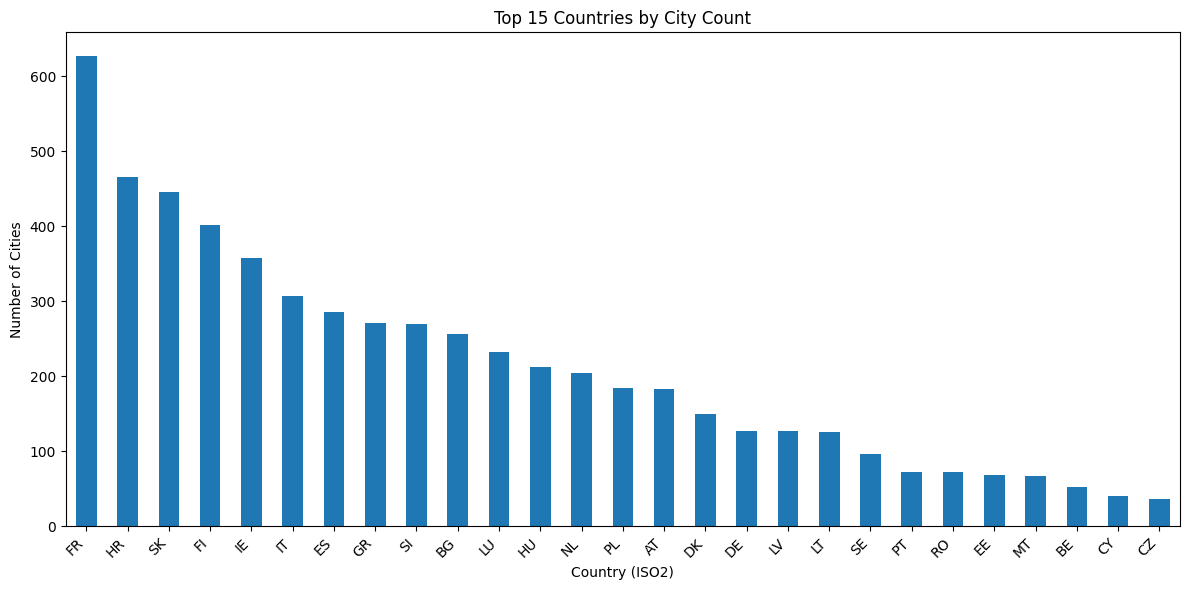

In [14]:
plot_hist_cities_by_country(df_cities)

##### Histogram interpretation

Data amount for each country does not follow a distinct pattern. Some countries display a very small amount of listings, which can be attributed to a lack of populated cities. Further validation is needed to verify the quality of original data. 

In [15]:
def plot_geo_cities(dataframe: pd.DataFrame):
    """Plot cities on a geographic scatter plot."""
    fig = px.scatter_geo(
        df_cities,
        lat="lat_city",
        lon="lng_city",
        color="country",
        hover_name="name_city",
        size="population",  # Encode population in marker size
        title="Cities in Europe by Population",
        opacity=0.6,
        height=650,
    )
    fig.update_traces(marker=dict(sizemin=2)) # Ensure even small cities are visible
    fig.update_geos(
        scope="europe",
        resolution=50,
        showland=True,
        landcolor="rgb(240, 240, 240)",
        showcountries=True,
        showsubunits=True,
        showcoastlines=True,
        coastlinecolor="rgb(80, 80, 80)",
        fitbounds="locations",
    )
    fig.show()

In [16]:
plot_geo_cities(df_cities)

Collected City grid is sparse, but as expected from the collected data. After 

#### 2.4 Data Quality Verification


##### Validity checks and expectations


In [17]:

# Create a box plot to show population distribution by country
fig = px.box(
    df_cities,
    x='country',
    y='population',
    title='Population Distribution by Country',
    labels={'population': 'Population', 'country': 'Country (ISO2)'},
    height=600
)
fig.show()

Distribution of Populations for each country look reasonable, no clearly identifiable contextual outliers

##### 2.5.2 Category or country-level summaries


#### 3.1 Create new columns


In [18]:
# Standardize text fields and align numeric types
df_cities["name_city"] = df_cities["name_city"].astype("string").str.strip()
df_cities["country"] = df_cities["country"].astype("string").str.upper().str.strip()
df_cities["is_capital"] = df_cities["capital"].str.lower().str.strip().eq("primary").fillna(False)
df_cities["population"] = pd.to_numeric(df_cities["population"], errors="coerce")

# Drop the original capital column as it's now replaced by is_capital
df_cities.drop(columns=["capital"], inplace=True)

In [19]:
display(df_cities[df_cities['is_capital'] == True])

,name_city,lat_city,lng_city,country,population,is_capital
0,Vienna,48.2083,16.3725,AT,1973403.0,True
183,Brussels,50.8467,4.3525,BE,1235192.0,True
236,Sofia,42.7000,23.3300,BG,1383435.0,True
492,Nicosia,35.1725,33.3650,CY,330000.0,True
533,Prague,50.0875,14.4214,CZ,1357326.0,True
570,Berlin,52.5200,13.4050,DE,3755251.0,True
699,Copenhagen,55.6761,12.5683,DK,660842.0,True
872,Tallinn,59.4372,24.7453,EE,461346.0,True
965,Madrid,40.4169,-3.7033,ES,3266126.0,True
1250,Helsinki,60.1708,24.9375,FI,664921.0,True


#### Select relevant Data for analysis:

Cities included in analysis should be capitals or major administrational cities. For simplicities capitals and cities by given population thresholds are selected (500K, 250K, 150K).
Furthermore cities on islands, not connected to the european rail system are excluded as well (e.g.:  Nicosia, Valetta). 

Cities to be excluded:
- Spanish Islands cities (Palma, ...)
- Greece islands (Heraklion, ....)
- Italy and France islands (Sardinia, Corsica, Sicily)

Exclusion in some cases might be redundant as later at join stage with timetables cities without stations should be excluded, but have in mind (for flights especially)

In [33]:
df_cities = df_cities[(df_cities["country"] != "MT") & (df_cities["country"] != "CY") & (df_cities["country"] != "IE") ]

In [45]:
print("Data dimensions before selection:", df_cities.shape)

# Filter cities with population over 500k or capitals
cities_500K = df_cities[(df_cities['population'] >= 500000) | (df_cities['is_capital'] == True)]
cities_250K = df_cities[(df_cities['population'] >= 250000) | (df_cities['is_capital'] == True)]
cities_150K = df_cities[(df_cities['population'] >= 150000) | (df_cities['is_capital'] == True)]

print("Data dimensions after selection (500K):", cities_500K.shape)
print("Data dimensions after selection (250K):", cities_250K.shape)
print("Data dimensions after selection (150K):", cities_150K.shape)

Data dimensions before selection: (5275, 6)
Data dimensions after selection (500K): (62, 6)
Data dimensions after selection (250K): (119, 6)
Data dimensions after selection (150K): (256, 6)


In [47]:
cities_500K

,name_city,lat_city,lng_city,country,population,is_capital
0,Vienna,48.2083,16.3725,AT,1973403.0,True
183,Brussels,50.8467,4.3525,BE,1235192.0,True
184,Antwerp,51.2178,4.4003,BE,536079.0,False
236,Sofia,42.7000,23.3300,BG,1383435.0,True
533,Prague,50.0875,14.4214,CZ,1357326.0,True
...,...,...,...,...,...,...
5037,Bucharest,44.4325,26.1039,RO,1716961.0,True
5110,Stockholm,59.3294,18.0686,SE,984748.0,True
5111,Gothenburg,57.7075,11.9675,SE,607882.0,False
5217,Ljubljana,46.0514,14.5061,SI,284293.0,True


In [46]:
display(cities_150K.sample(26, random_state=1))

,name_city,lat_city,lng_city,country,population,is_capital
4359,Riga,56.9489,24.1064,LV,660187.0,True
587,Bielefeld,52.0211,8.5347,DE,338332.0,False
4576,Amsterdam,52.3728,4.8936,NL,917923.0,True
4974,Matosinhos,41.1833,-8.7000,PT,175478.0,False
4797,Sosnowiec,50.2833,19.1333,PL,193660.0,False
3954,Klaipėda,55.7125,21.1350,LT,158420.0,False
3651,Bologna,44.4939,11.3428,IT,387971.0,False
580,Bremen,53.0758,8.8072,DE,569396.0,False
2297,Thessaloníki,40.6403,22.9347,GR,309617.0,False
4578,The Hague,52.0800,4.3100,NL,548320.0,True


#### Exporting Dataset


In [37]:
# Define the output path for the filtered dataset
cities_500K_path = Path('..') / 'Processed_Data' / 'cities_500K.csv '
cities_250K_path = Path('..') / 'Processed_Data' / 'cities_250K.csv '
cities_150K_path = Path('..') / 'Processed_Data' / 'cities_150K.csv '

# Export the DataFrame to a CSV file
cities_500K.to_csv(cities_500K_path, index=False, encoding='utf-8')
print(f"Filtered city data saved to {cities_500K_path}")

cities_250K.to_csv(cities_250K_path, index=False, encoding='utf-8')
print(f"Filtered city data saved to {cities_250K_path}")

cities_150K.to_csv(cities_150K_path, index=False, encoding='utf-8')
print(f"Filtered city data saved to {cities_150K_path}")

Filtered city data saved to ..\Processed_Data\cities_500K.csv 
Filtered city data saved to ..\Processed_Data\cities_250K.csv 
Filtered city data saved to ..\Processed_Data\cities_150K.csv 


In [56]:
def plot_geo_cities2(dataframe: pd.DataFrame):
    """Plot cities on a geographic scatter plot."""
    fig = px.scatter_geo(
        dataframe,
        lat="lat_city",
        lon="lng_city",
        color="country",
        hover_name="name_city",
        hover_data={"population": True, "lat_city": False, "lng_city": False},
        size="population",  # Encode population in marker size
        title="Cities in Europe by Population",
        opacity=0.6,
        height=650,
    )

    fig.update_geos(
        scope="europe",
        resolution=50,
        showland=True,
        landcolor="rgb(240, 240, 240)",
        showcountries=True,
        showsubunits=True,
        showcoastlines=True,
        coastlinecolor="rgb(100, 100, 100)",
        fitbounds="locations",
    )
    
    fig.update_layout(height=700, width=1200)
    return fig

plot_geo_cities2(cities_500K)

In [57]:
plot_geo_cities2(cities_250K)

In [58]:
plot_geo_cities2(cities_150K)